In [ ]:
# import os
# import shutil
# from sklearn.model_selection import train_test_split

# input_dir = '/content/drive/MyDrive/final'
# output_dir = '/content/drive/MyDrive/dataset'
# classes = ['100', '200', '500', '2000']

# train_ratio = 0.7
# val_ratio = 0.15
# test_ratio = 0.15

# for split in ['train', 'val', 'test']:
#     for cls in classes:
#         os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

# for cls in classes:
#     cls_path = os.path.join(input_dir, cls)
#     images = [f for f in os.listdir(cls_path) if f.endswith('.jpg')]
#     full_paths = [os.path.join(cls_path, f) for f in images]

#     train_imgs, temp_imgs = train_test_split(full_paths, train_size=train_ratio, random_state=42)
#     val_imgs, test_imgs = train_test_split(temp_imgs, test_size=test_ratio / (val_ratio + test_ratio), random_state=42)

#     for img_path in train_imgs:
#         shutil.copy(img_path, os.path.join(output_dir, 'train', cls))
#     for img_path in val_imgs:
#         shutil.copy(img_path, os.path.join(output_dir, 'val', cls))
#     for img_path in test_imgs:
#         shutil.copy(img_path, os.path.join(output_dir, 'test', cls))

# print("Dataset split complete!", output_dir)


In [ ]:
import cv2
import numpy as np
import os

image_size = 512

def get_data(data_dir):
    images = []
    img_labels = []
    class_names = sorted(os.listdir(data_dir))

    for label in class_names:
        path = os.path.join(data_dir, label)
        class_num = class_names.index(label)

        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path)
                if img_arr is None:
                    continue

                resized_arr = cv2.resize(cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB), (image_size, image_size))
                images.append(resized_arr)
                img_labels.append(class_num)
            except Exception as e:
                print(f"Error with {img_path}: {e}")

    return np.array(images), np.array(img_labels), class_names


# **EDA**


1.   check for class imbalence
2.    check for that all classes are present





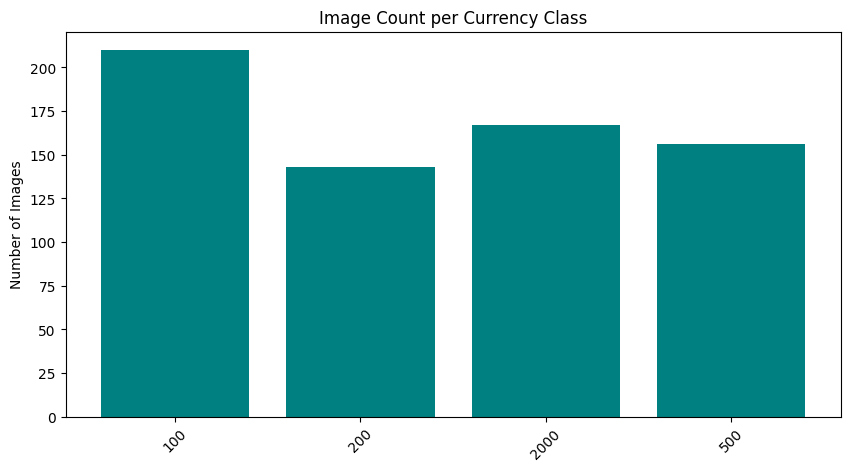

In [ ]:
import os
import matplotlib.pyplot as plt

base_dir = '/content/drive/MyDrive/dataset/train'
classes = sorted(os.listdir(base_dir))


class_counts = {}
for c in classes:
    class_counts[c] = len(os.listdir(os.path.join(base_dir, c)))

plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='teal')
plt.title('Image Count per Currency Class')
plt.xticks(rotation=45)
plt.ylabel('Number of Images')
plt.show()


# **Preprocessing**
1.   loading data in to train,val,test
2.   normalize the images according to the architecture like vgg_16,mobilenet
3.   onehotencoding on class labels
    




In [ ]:
from tensorflow.keras.utils import to_categorical

train_path = '/content/drive/MyDrive/dataset/train'
val_path = '/content/drive/MyDrive/dataset/val'
test_path = '/content/drive/MyDrive/dataset/test'

train_images, train_labels, class_names = get_data(train_path)
val_images, val_labels, _ = get_data(val_path)
test_images, test_labels, _ = get_data(test_path)

x_train = np.array(train_images).astype('float32') / 255
x_val = np.array(val_images).astype('float32') / 255
x_test = np.array(test_images).astype('float32') / 255

y_train = to_categorical(train_labels, num_classes=len(class_names))
y_val = to_categorical(val_labels, num_classes=len(class_names))
y_test = to_categorical(test_labels, num_classes=len(class_names))


In [ ]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(676, 512, 512, 3)
(145, 512, 512, 3)
(147, 512, 512, 3)


In [ ]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(676, 4)
(145, 4)
(147, 4)


# **Perform data agumentation on train and validation data with different parameters**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(x_train, y_train, batch_size=8, shuffle=True)
val_generator = val_datagen.flow(x_val, y_val, batch_size=8, shuffle=False)


# **CNN model building with Transfer Learning (MobileNet architecture)**

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(512, 512, 3))
mobilenet_base.trainable = False

model = Sequential([
    mobilenet_base,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()



/tmp/ipython-input-12-2315590051.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(512, 512, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 16, 16, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,426,212 (9.26 MB)

 Trainable params: 168,228 (657.14 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

<h2>Hyperparameter Tuning Summary</h2>

<table style="font-size:30 px">
  <tr>
    <th>Hyperparameter</th>
    <th>Tried With</th>
  </tr>
  <tr>
    <td>Learning Rate</td>
    <td>0.0001</td>
  </tr>
  <tr>
    <td>Batch Size</td>
    <td>4, 8, 32</td>
  </tr>
  <tr>
    <td>Optimizer</td>
    <td>Adam</td>
  </tr>
  <tr>
    <td>Dense Units</td>
    <td>32, 64, 128, 256, 512</td>
  </tr>
  <tr>
    <td>Dropout Rate</td>
    <td>0.2, 0.3, 0.35</td>
  </tr>
  <tr>
    <td>Epochs</td>
    <td>10, 30, 50</td>
  </tr>
</table>


# **Training**





In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 65s 611ms/step - accuracy: 0.4072 - loss: 1.3019 - val_accuracy: 0.8483 - val_loss: 0.6456
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 40s 475ms/step - accuracy: 0.7699 - loss: 0.6618 - val_accuracy: 0.9103 - val_loss: 0.3423
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 40s 465ms/step - accuracy: 0.8438 - loss: 0.4595 - val_accuracy: 0.9241 - val_loss: 0.2173
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 40s 474ms/step - accuracy: 0.8832 - loss: 0.3230 - val_accuracy: 0.9448 - val_loss: 0.1878
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 462ms/step - accuracy: 0.9218 - loss: 0.2277 - val_accuracy: 0.9655 - val_loss: 0.1268
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 40s 475ms/step - accuracy: 0.9553 - loss: 0.1534 - val_accuracy: 0.9655 - val_loss: 0.1352
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 40s 472ms/step - accuracy: 0.9405 - loss: 0.1710 - val_accuracy: 0.9586 - val_loss: 0.1076
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 465ms/step - accuracy: 0.9518 - loss: 0.1215 - val_accu

# **Evaluation**

In [ ]:

test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(x_test, y_test, batch_size=8, shuffle=False)

test_loss, test_acc =model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - accuracy: 0.9945 - loss: 0.0380
Test Accuracy: 99.32%


# **Confusion Matrix**

5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step


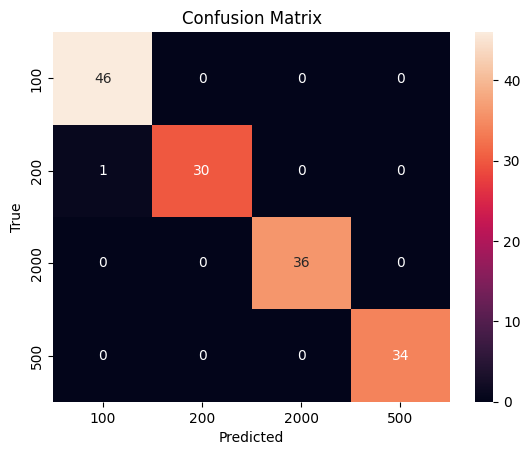

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()




# **Classification Report**

In [ ]:
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

              precision    recall  f1-score   support

         100       0.98      1.00      0.99        46
         200       1.00      0.97      0.98        31
        2000       1.00      1.00      1.00        36
         500       1.00      1.00      1.00        34

    accuracy                           0.99       147
   macro avg       0.99      0.99      0.99       147
weighted avg       0.99      0.99      0.99       147



# **Plot Train_Accuracy VS Validation_Accuracy**

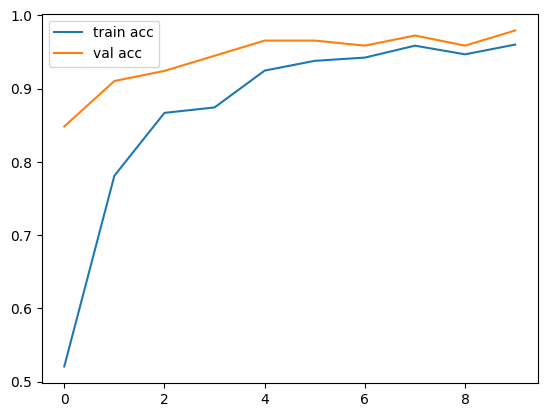

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


# **Save Model**

In [ ]:

# model.save('/content/drive/MyDrive/currency_note_model.h5')
# print(" Model saved!")


# **Show Random Predictions**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

y_hat = model.predict(x_test)
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_test, axis=1)

fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(len(x_test), size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i+1, xticks=[], yticks=[])
    ax.imshow(x_test[idx])

    pred_label = class_names[y_pred[idx]]
    true_label = class_names[y_true[idx]]

    ax.set_title(f"{pred_label} ({true_label})",
                 color=("blue" if pred_label == true_label else "red"))

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

model=load_model('/content/drive/MyDrive/currency_note_model.h5')

# **Prediction with Out Side Images**

In [ ]:
import cv2
import numpy as np
import os

def predict_single_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print("Image not found or invalid.")
        return

    img = cv2.resize(img[..., ::-1], (512, 512))
    img = np.expand_dims(img, axis=0).astype('float32') / 255.0

    prediction = model.predict(img)
    train_path = '/content/drive/MyDrive/dataset/train'
    class_names = sorted(os.listdir(train_path))

    predicted_class = class_names[np.argmax(prediction)]
    print(f"Predicted class: {predicted_class}")


predict_single_image('/content/drive/MyDrive/100.jpg')

In [ ]:
import cv2
import numpy as np
import os

def predict_single_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print("Image not found or invalid.")
        return

    img = cv2.resize(img[..., ::-1], (512, 512))
    img = np.expand_dims(img, axis=0).astype('float32') / 255.0

    prediction = model.predict(img)
    train_path = '/content/drive/MyDrive/dataset/train'
    class_names = sorted(os.listdir(train_path))

    predicted_class = class_names[np.argmax(prediction)]
    print(f"Predicted class: {predicted_class}")


predict_single_image('/content/drive/MyDrive/200.jpg')

In [ ]:
import cv2
import numpy as np
import os

def predict_single_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print("Image not found or invalid.")
        return

    img = cv2.resize(img[..., ::-1], (512, 512))
    img = np.expand_dims(img, axis=0).astype('float32') / 255.0

    prediction = model.predict(img)
    train_path = '/content/drive/MyDrive/dataset/train'
    class_names = sorted(os.listdir(train_path))

    predicted_class = class_names[np.argmax(prediction)]
    print(f"Predicted class: {predicted_class}")


predict_single_image('/content/drive/MyDrive/500.jpg')

In [ ]:
import cv2
import numpy as np
import os

def predict_single_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print("Image not found or invalid.")
        return

    img = cv2.resize(img[..., ::-1], (512, 512))
    img = np.expand_dims(img, axis=0).astype('float32') / 255.0

    prediction = model.predict(img)
    train_path = '/content/drive/MyDrive/dataset/train'
    class_names = sorted(os.listdir(train_path))

    predicted_class = class_names[np.argmax(prediction)]
    print(f"Predicted class: {predicted_class}")


predict_single_image('/content/drive/MyDrive/2000.jpg')